In [1]:
# load required libraries & modules
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
import pprint
import time
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch

from utils import *
from loaddata import *
# from visualization import *
from ourmodel import *

torch.set_grad_enabled(False)
torch.set_printoptions(sci_mode=False)

DATA_DIR = '../data'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

BATCHSIZE = 100

# PATH_MNISTC = '../data/MNIST_C/'
# CORRUPTION_TYPES = ['identity', 
#          'shot_noise', 'impulse_noise','glass_blur','motion_blur',
#          'shear', 'scale',  'rotate',  'brightness',  'translate',
#          'stripe', 'fog','spatter','dotted_line', 'zigzag',
#          'canny_edges']

# CORRUPTION_INTEREST = ['glass_blur','motion_blur', 'impulse_noise','shot_noise',
#         'fog','dotted_line','spatter', 'zigzag']

ACC_TYPE = "entropy"

#################
# model load
################
def load_model(args):
    # load model
    model = RRCapsNet(args).to(args.device) 
    model.load_state_dict(torch.load(args.load_model_path))
    return model

def load_args(load_model_path, args_to_update, verbose=False):
    params_filename = os.path.dirname(load_model_path) + '/params.txt'
    assert os.path.isfile(params_filename), "No param flie exists"
    args = parse_params_wremove(params_filename, removelist = ['device']) 
    args = update_args(args, args_to_update)
    args.load_model_path = load_model_path
    if verbose:
        pprint.pprint(args.__dict__, sort_dicts=False)
    return args

############
# testing 
############
def predict(model, args, x):    
    with torch.no_grad():        
        objcaps_len_step, x_recon_step = model(x)
    return objcaps_len_step, x_recon_step



def test_model_on_dataloader(model, args, dataloader, acc_type=ACC_TYPE):
    acclist = []
    nsteplist = []
    
    model.eval()
    
    # load batch data
    for data in dataloader:
        if len(data)==2:
            x, y = data
            gtx = None
            x= x.to(args.device) 
            y= y.to(args.device) 

        elif len(data)==3:
            x, gtx, y = data
            x= x.to(args.device) 
            y= y.to(args.device) 
            gtx =gtx.to(args.device) 
        num_classes = y.size(dim=1) #onehot vector

        # predict
        objcaps_len_step, x_recon_step = predict(model, args, x)
        objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=num_classes) # in case a background cap was added    

        # evaluate
        if acc_type == 'entropy':
            if args.time_steps==1:
                y_pred = objcaps_len_step_narrow[:,-1]
                accs = topkacc(y_pred, y, topk=1)
                nstep = torch.ones(accs.size(), device=accs.device)
            else:
                accs, final_pred, nstep, no_stop_condition, entropy = compute_entropy_based_acc(objcaps_len_step_narrow, y,  threshold=0.6, use_cumulative = False, only_acc=False)
        else:
            raise NotImplementedError

        acclist.append(accs) 
        nsteplist.append(nstep)
        
    # average acc and nstep (on accurate trials)
    cataccs = torch.cat(acclist)
    catnsteps = torch.cat(nsteplist)
    acc_mean = cataccs.mean().item()
#     (accs*nstep).sum()/((accs*nstep)!=0).sum()
    nstep_mean_correct =(cataccs*catnsteps).sum().item()/((cataccs*catnsteps)!=0).sum().item()
#     nstep_mean = torch.cat(nsteplist).to(torch.float).mean().item()
    
    return acc_mean, nstep_mean_correct


/home/young/miniconda3/envs/modelvshuman/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load model

In [4]:
print_args =False
args_to_update = {'device':DEVICE, 'batch_size':BATCHSIZE, 
                 'time_steps': 1, 'routings': 1, 'mask_threshold': 0.1}
load_model_path = "./model/our/best_epoch89_acc0.9619.pt"

# load args and model  
args = load_args(load_model_path, args_to_update, print_args)
model = load_model(args)
model.eval()
model.training
# dataloader = fetch_dataloader(task='imagenet-16', batch_size = 100, train=False)
# acc_mean, nstep_mean_correct = test_model_on_dataloader(model, args, dataloader)


=========== model instantiated like below: =============
TASK: imagenet-16 (# targets: 1, # classes: 16, # background: 0)
TIMESTEPS #: 1
ENCODER: resnet w/ conv1x1 projection
...resulting primary caps #: 3136, dim: 8
ROUTINGS # 1
Object #: 16, BG Capsule #: 0
DECODER: resnet, w/ conv1x1 projection
...recon only one object capsule: True



False

In [5]:
# for name, module in model.named_modules():
#     print(name)

# extract features from the images used in the fMRI experiment

In [26]:
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from collections import defaultdict

# transformation function
from PIL import Image
from torchvision.transforms import transforms

d_idx2name = {}
with open('./model/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_idx2name[int(parts[0])] =  parts[1] # idx --> name 
        
d_name2idx = {}
with open('./model/imagenet-16-train_name.txt') as f:
    for line in f:
        parts = line.rstrip().split(' ')
        d_name2idx[parts[1]] =  int(parts[0]) # idx --> name 

======= start  exp_sf
start analysis on HP
start extraction on car,  0.3
start extraction on chair,  0.9
start extraction on elephant,  0.7
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object
start analysis on LP
start extraction on car,  0.0
start extraction on chair,  0.0
start extraction on elephant,  0.9
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object


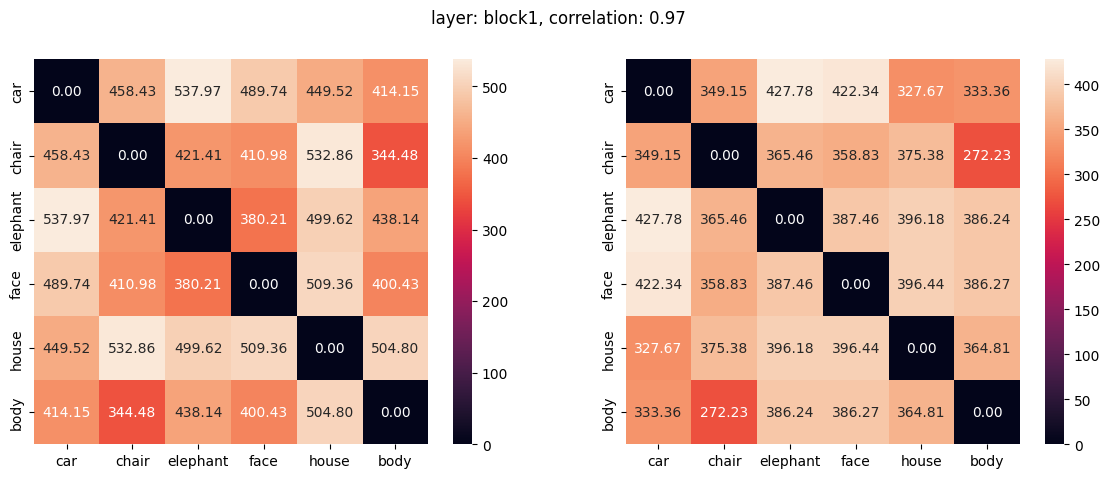

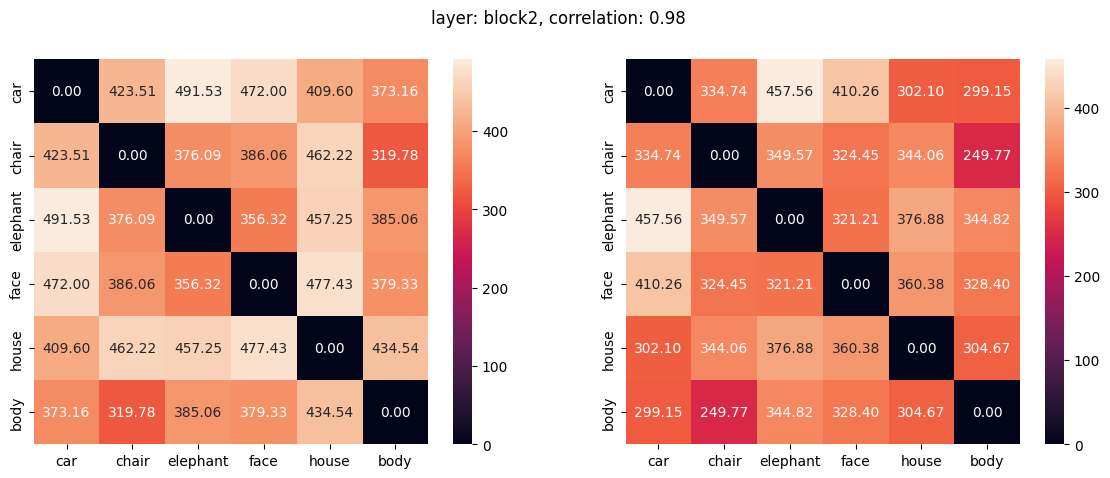

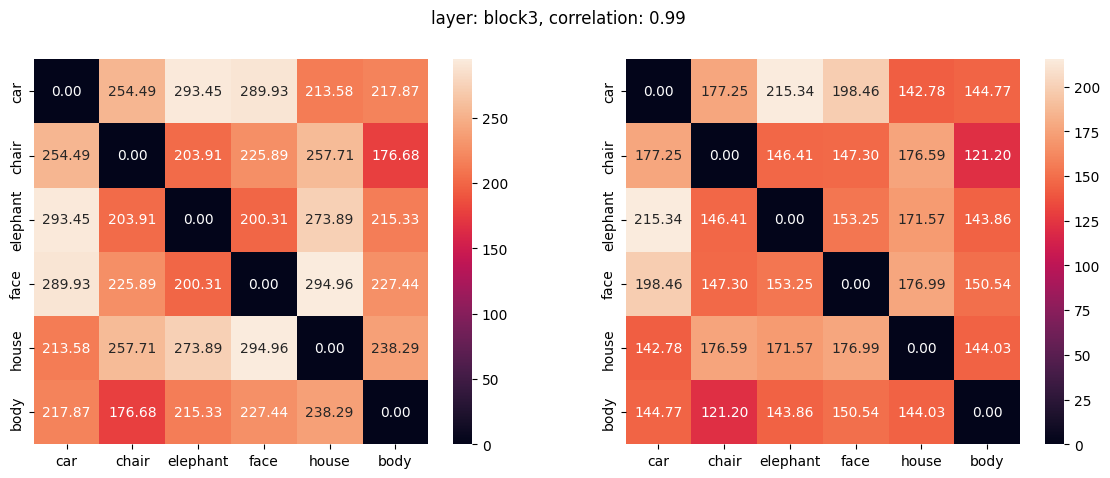

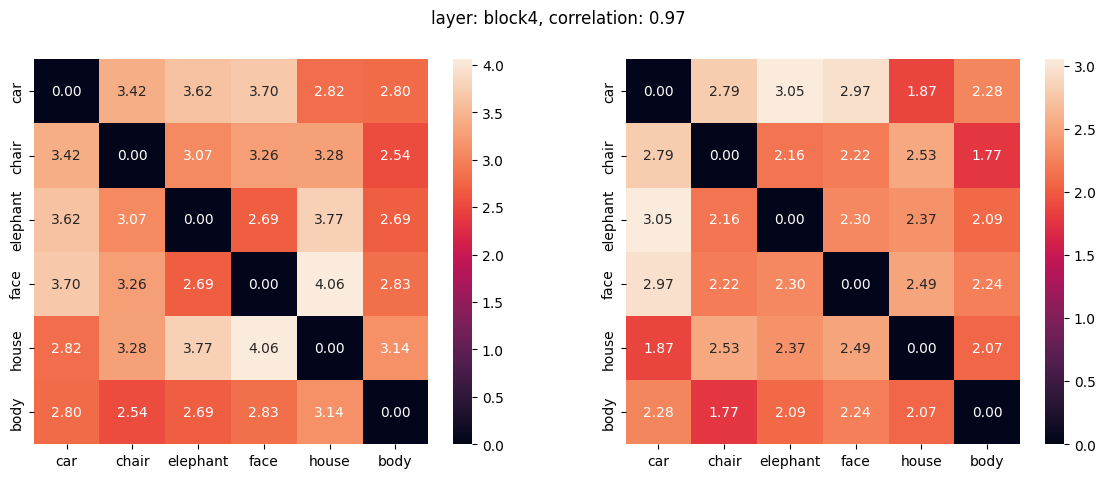

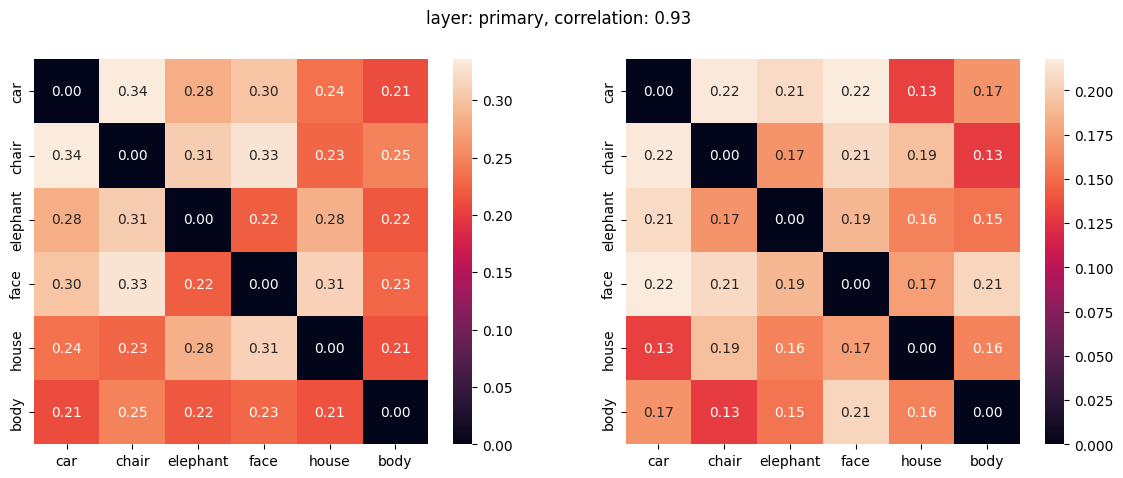

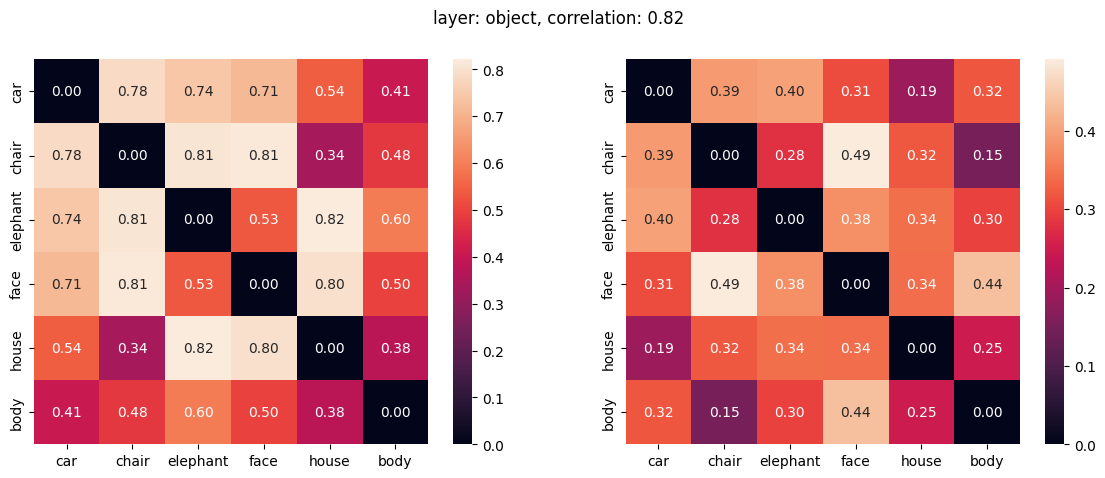

======= start  exp_position
start analysis on 1
start extraction on car,  0.2
start extraction on chair,  0.0
start extraction on elephant,  0.1
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.3
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object
start analysis on 2
start extraction on car,  0.1
start extraction on chair,  0.1
start extraction on elephant,  0.4
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.3
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object


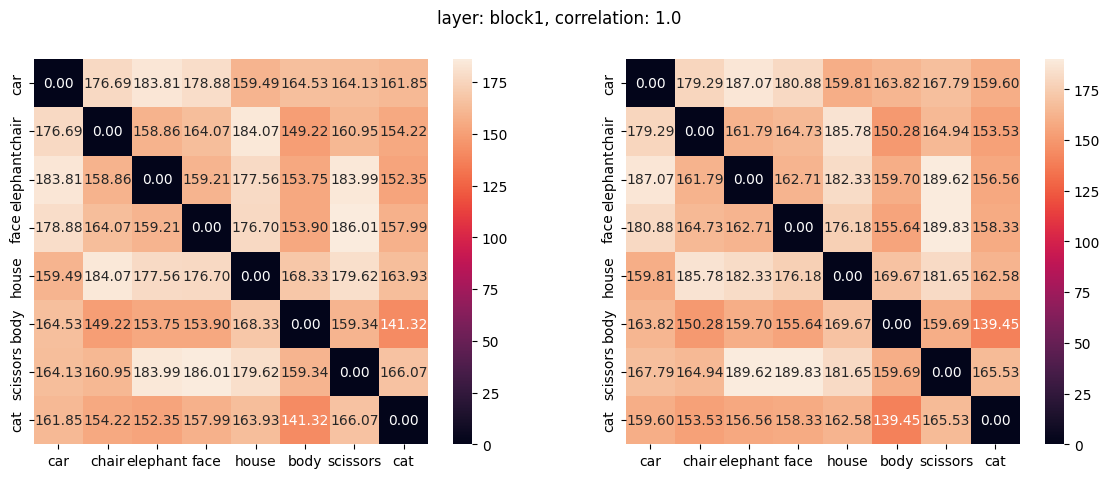

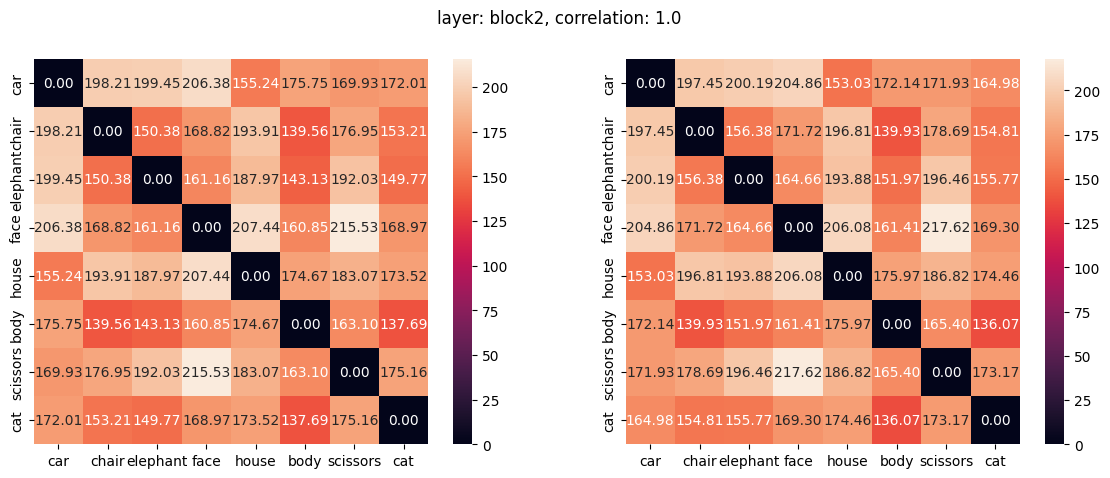

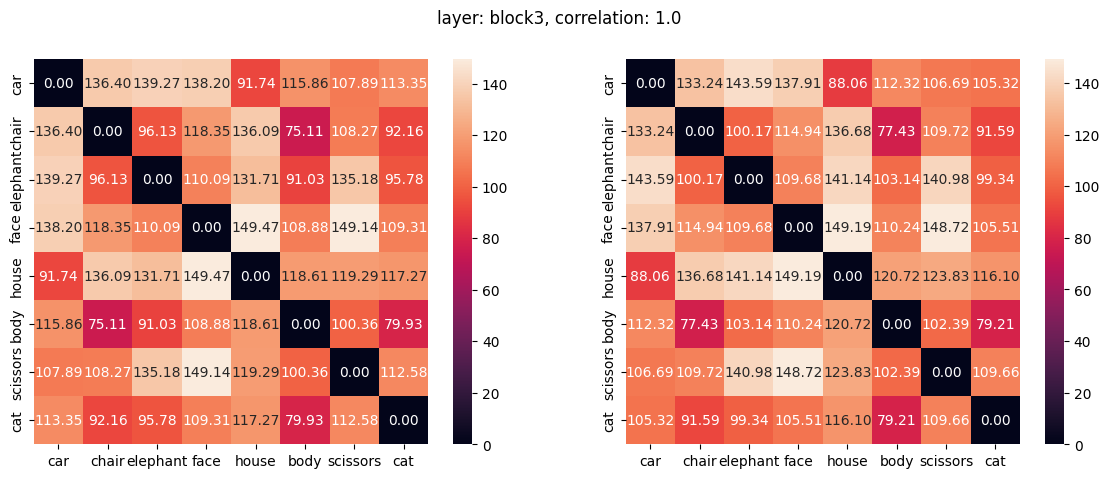

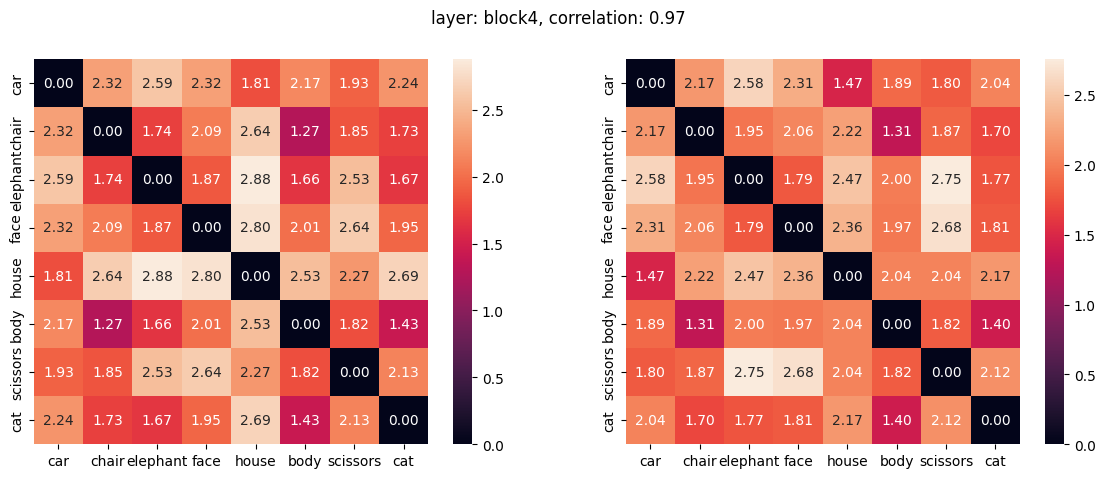

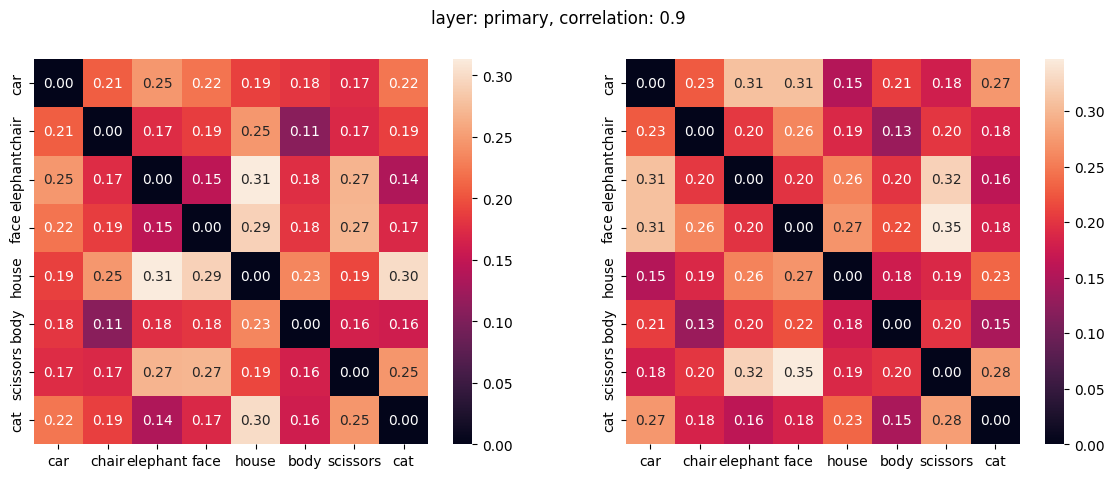

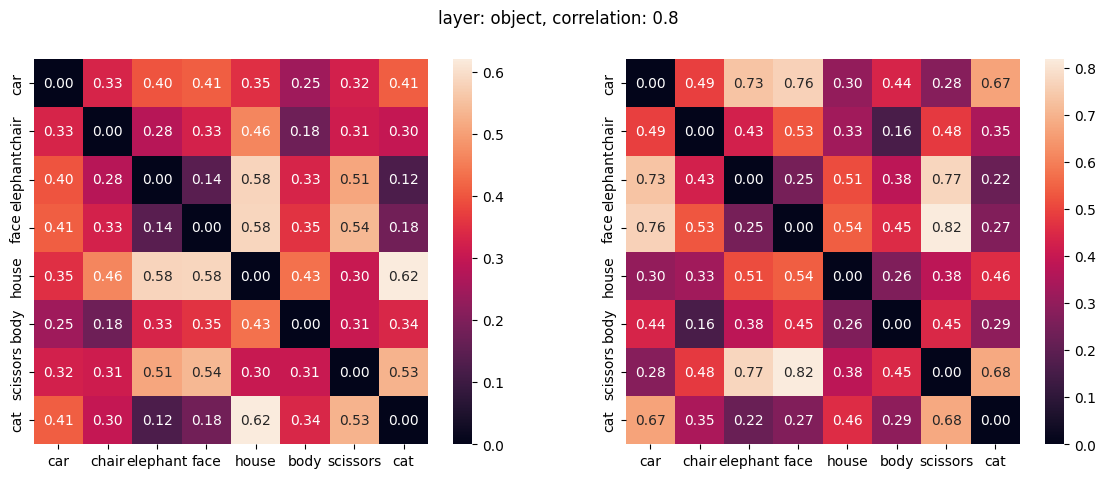

======= start  exp_size
start analysis on 1
start extraction on car,  0.0
start extraction on chair,  0.0
start extraction on elephant,  0.2
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.1
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object
start analysis on 2
start extraction on car,  0.8
start extraction on chair,  0.3
start extraction on elephant,  1.0
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.7
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object


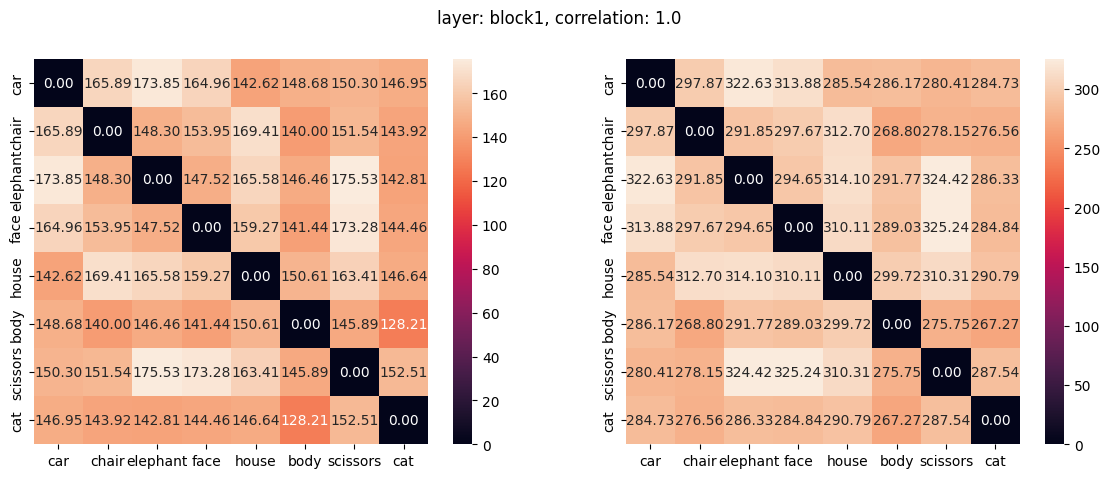

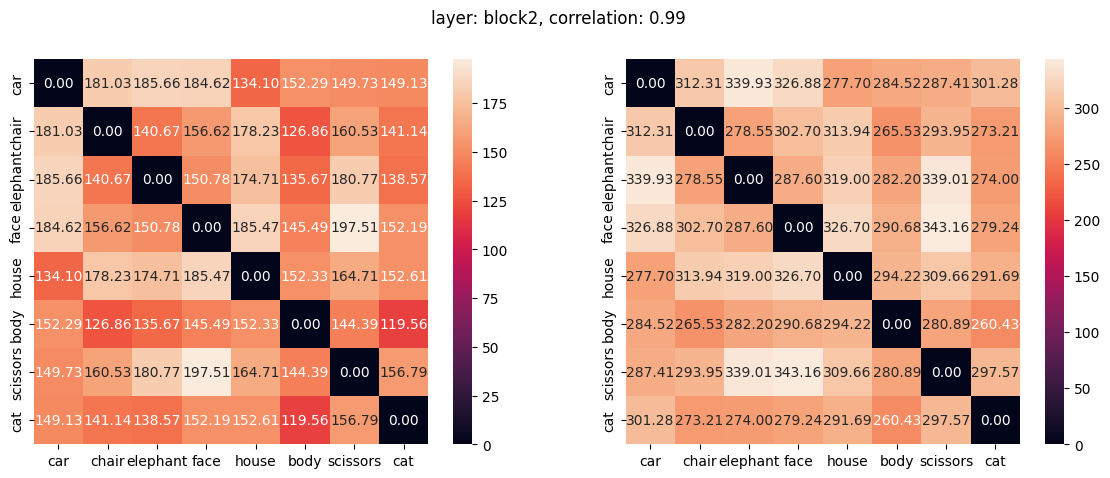

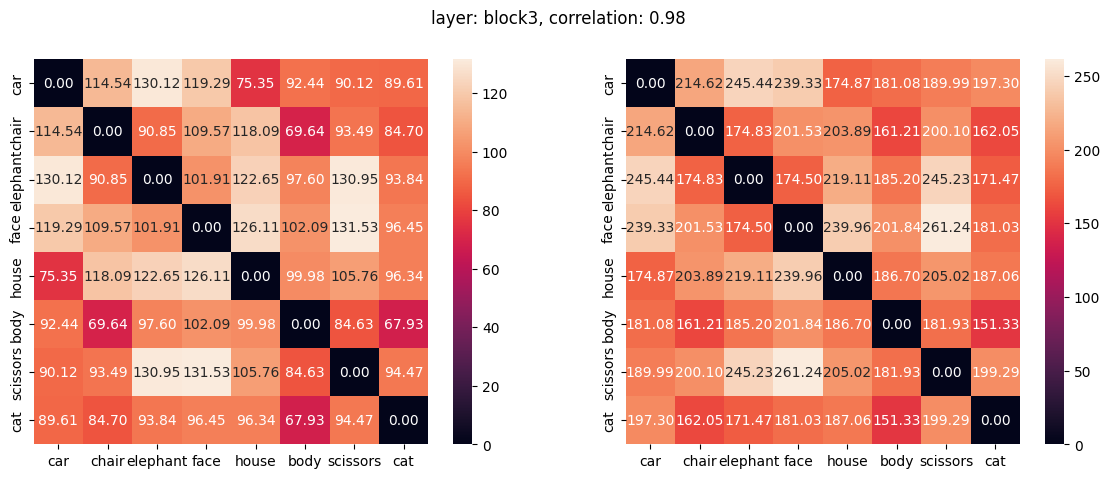

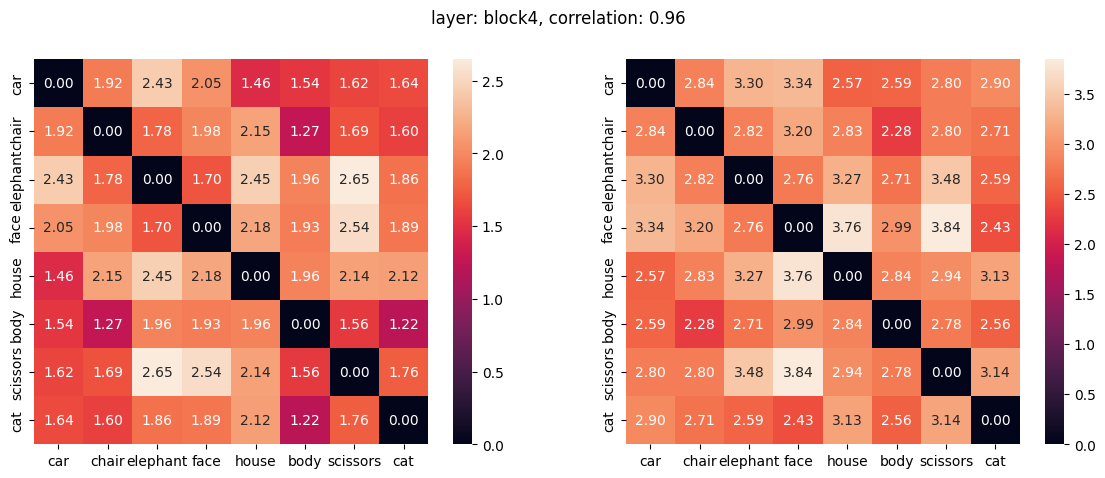

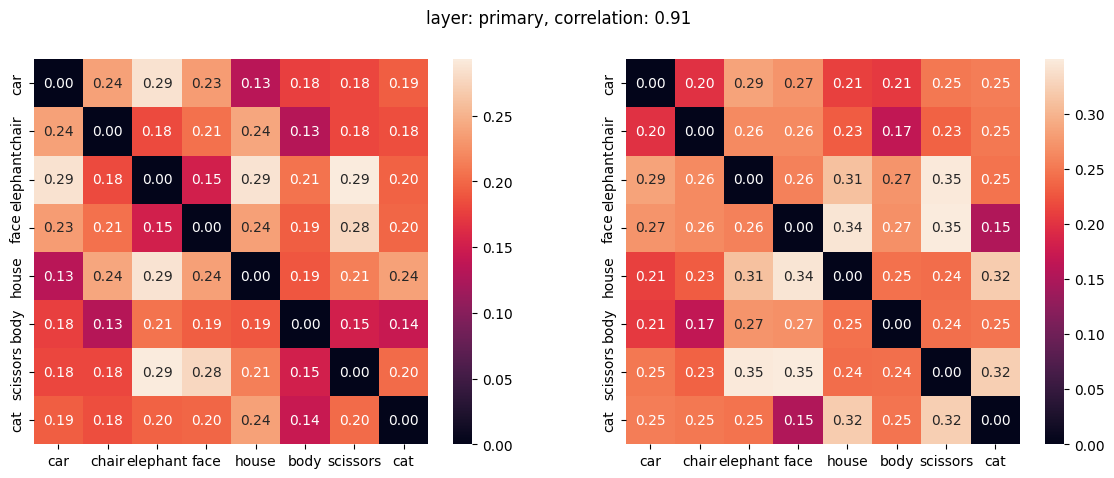

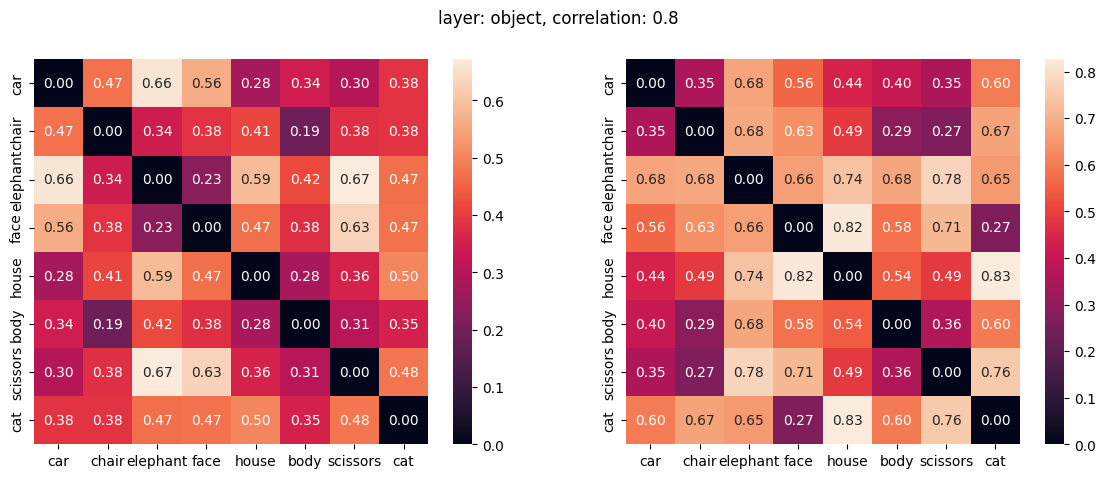

======= start  exp_stats
start analysis on 1
start extraction on car,  1.0
start extraction on chair,  0.7
start extraction on elephant,  0.9
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.8
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object
start analysis on 2
start extraction on car,  0.8
start extraction on chair,  0.3
start extraction on elephant,  1.0
start extraction on face,  NA
start extraction on house,  NA
start extraction on body,  NA
start extraction on scissors,  NA
start extraction on cat,  0.7
start rdm analysis on  block1
start rdm analysis on  block2
start rdm analysis on  block3
start rdm analysis on  block4
start rdm analysis on  primary
start rdm analysis on  object


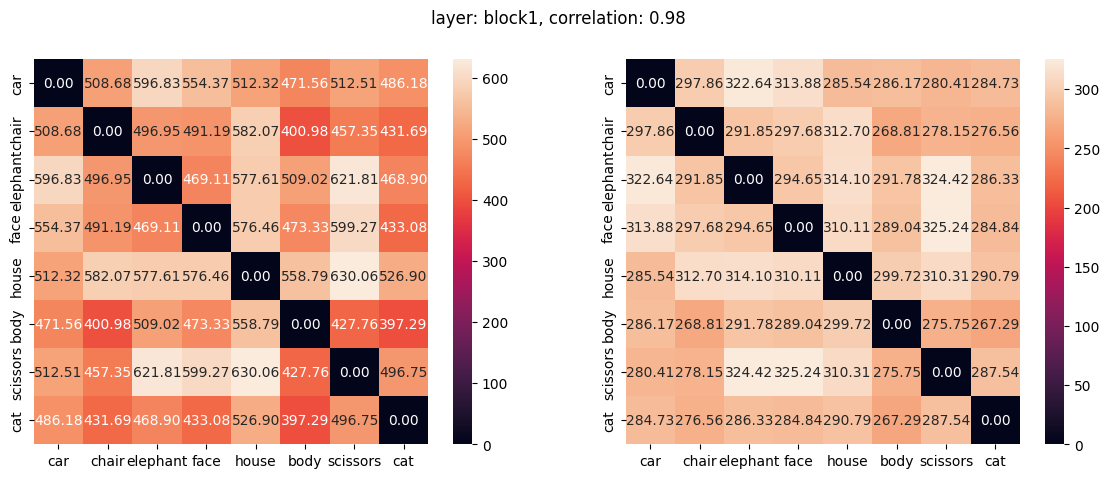

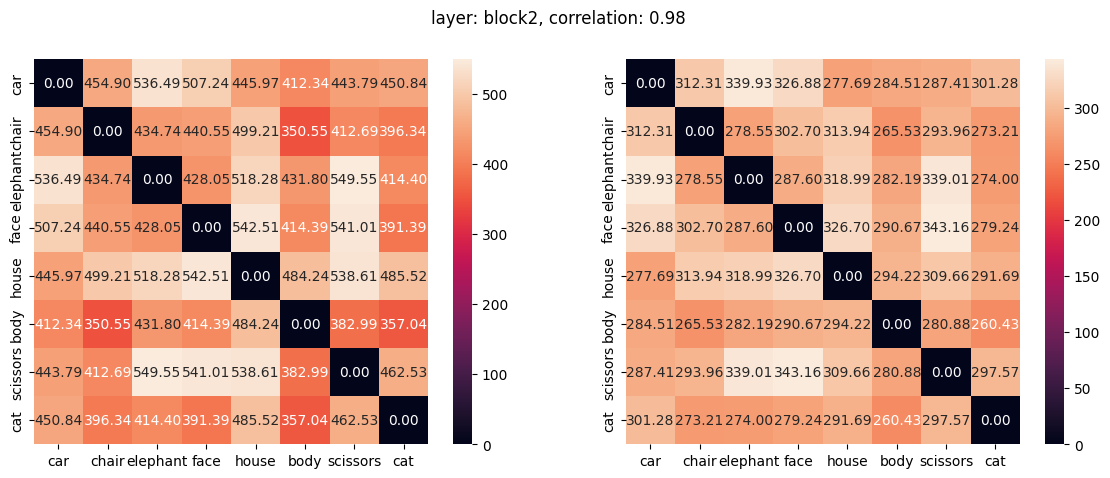

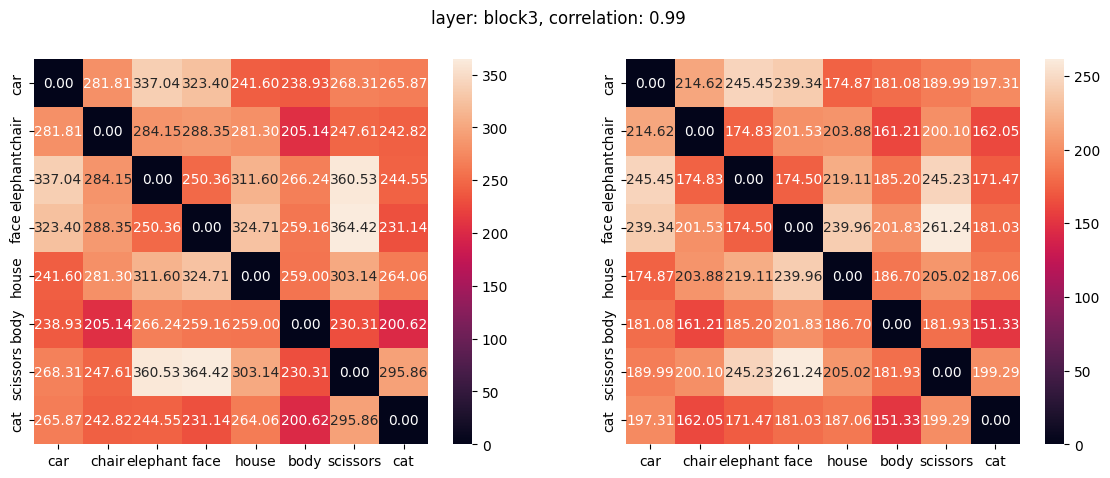

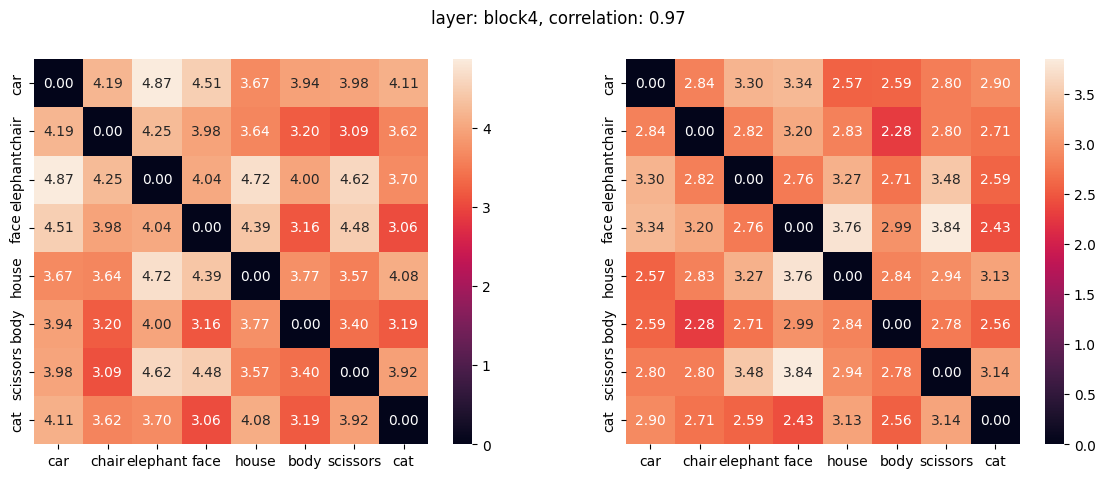

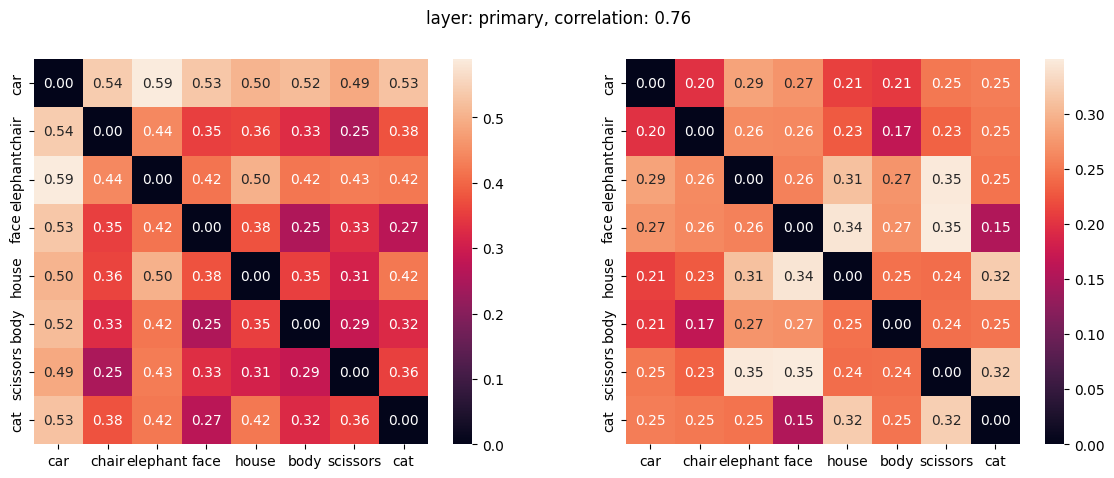

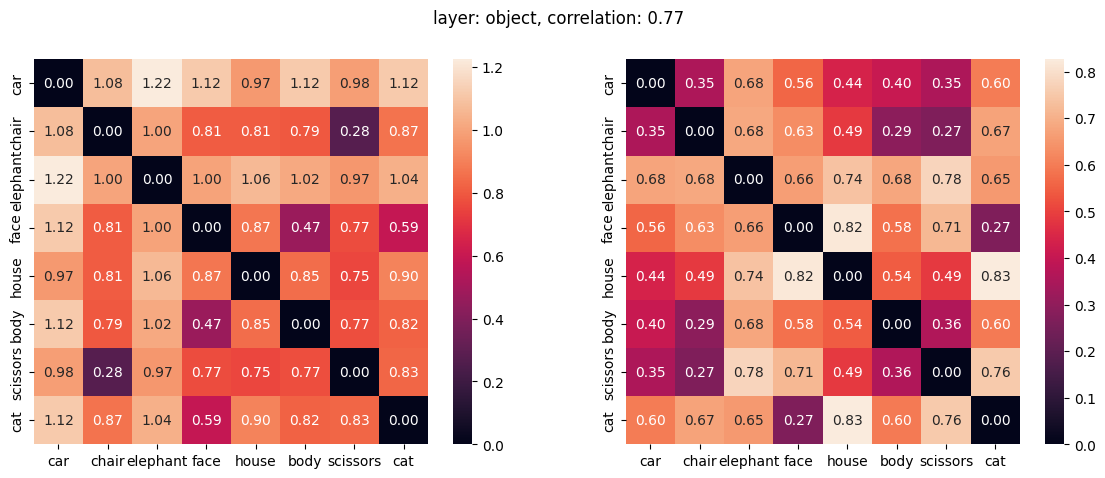

In [48]:
d_result= {}
DISTANCE_METRIC = 'euclidean' #'euclidean'

for expname in ['exp_sf','exp_position', 'exp_size', 'exp_stats']:
    print('======= start ', expname)
    # expname = 'exp_sf'
    # expname = 'exp_position'
    # expname = 'exp_size'
    # expname = 'exp_stats'

    if expname == 'exp_sf':
        conditions = ['HP', 'LP']
        categories =  ['car', 'chair', 'elephant', 'face', 'house', 'body']
#         categories =  ['car', 'chair', 'elephant']
    else:
        conditions = ['1', '2']
        categories =  ['car', 'chair', 'elephant', 'face', 'house', 'body', 'scissors', 'cat']
#         categories =  ['car', 'chair', 'elephant', 'cat']
#         categories = ['car', 'elephant', 'chair']

    n_instance = 10

    feature_name = ['block1', 'block2', 'block3', 'block4', 'primary', 'object']

    d_rdm = defaultdict(dict)
    for condition in conditions:
        print('start analysis on', condition)
        d_features = defaultdict(dict)

        for category in categories:
        #     category = 'chair'
            
            # load images in batch
            imgs=[]
            for i in range(1,n_instance+1):
                path_image = f'./data/{expname}/visual_images/{category}{condition}/{category}{i}.jpg'    
                img = Image.open(path_image).convert('RGB') 
                if img is None:
                    print(im_name)
                img = val_trans(img)
                imgs.append(img)


            # register hooks for feature extraction
            features = []

            def get_outputs():
                def hook(model, input, output):
                    features.append(output.detach())
                return hook

            def get_routingoutputs():
                def hook(model, input, output):
                    features.append(output[0].detach())
                return hook

            hook1 = model.encoder.enc.conv2.register_forward_hook(get_outputs())
            hook2 = model.encoder.enc.conv3.register_forward_hook(get_outputs())
            hook3 = model.encoder.enc.conv4.register_forward_hook(get_outputs())
            hook4 = model.encoder.enc.conv5.register_forward_hook(get_outputs())
            hook5 = model.encoder.capsulate.register_forward_hook(get_outputs())
            hook6 = model.capsule_routing.register_forward_hook(get_routingoutputs())

            # predict
            x = torch.stack(imgs).to(args.device)
            objcaps_len_step, x_recon_step = predict(model, args, x)
            
            hook1.remove()
            hook2.remove()
            hook3.remove()
            hook4.remove()
            hook5.remove()
            hook6.remove()
            
            # accuracy
            objcaps_len_step_narrow = objcaps_len_step.narrow(dim=-1,start=0, length=16) # in case a background cap was added    
            y_pred = objcaps_len_step_narrow[:,-1]
            topk_indices = y_pred.topk(3, sorted=True)[1]
            if category in d_name2idx.keys():
                correct_idx = d_name2idx[category]
                correct_trial = [True if correct_idx in toklist else False for toklist in topk_indices]
            # topk_indices = list(topk_indices.flatten().cpu().numpy())
            # predictions = [d_idx2name[int(idx)] for idx in topk_indices]
            # print(predictions)
                print(f'start extraction on {category}, ', np.mean(correct_trial))
            else:
                print(f'start extraction on {category}, ', 'NA')
#             if np.array(correct_trial).any() ==False:
#                 print(category)
#                 raise Error
            

            for i, f in enumerate(features):
            #     print(f.shape)
#                 avg_f = f[correct_trial].mean(dim=0).cpu().numpy().flatten()
                avg_f = f.mean(dim=0).cpu().numpy().flatten()
            #     print(avg_f.shape)
                d_features[feature_name[i]][category] = avg_f.flatten()

        for feature in feature_name:
            print('start rdm analysis on ', feature)
        #     feature = 'object'
            mat = []
            for cat in categories:
                mat.append(d_features[feature][cat])
            mat = np.array(mat)
            pdmat = pairwise_distances(mat, metric=DISTANCE_METRIC)

            d_rdm[feature][condition] = pdmat 
            
            
    # save data
    correlation= []
    for feature in feature_name:
        mats = []
        for condition in d_rdm[feature].keys():
            mats.append(d_rdm[feature][condition])
            
            
        c = pearsonr(mats[0].flatten(), mats[1].flatten())[0] #spearmanr
        correlation.append(c) 
        
        plt.rcParams["figure.figsize"] = (14,5)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'layer: {feature}, correlation: {round(c,2)}')
        sns.heatmap(mats[0], annot=True, fmt=".2f", ax=ax1, xticklabels=categories, yticklabels=categories)
        sns.heatmap(mats[1], annot=True, fmt=".2f", ax=ax2, xticklabels=categories, yticklabels=categories)
        plt.show()


    d_result[expname] =correlation

In [33]:
d_result

{'exp_sf': [0.9722584025368318,
  0.9787891058171483,
  0.9881676901410251,
  0.9661600303498096,
  0.9272381192644611,
  0.8201785791430393],
 'exp_position': [0.9993535558867125,
  0.9987248150542938,
  0.9957839909171329,
  0.9679840171455856,
  0.899364326624822,
  0.7968364426872427],
 'exp_size': [0.9955205394578572,
  0.9885251591517472,
  0.9827567130863983,
  0.9560880295474753,
  0.9052137638795925,
  0.7965741755580058],
 'exp_stats': [0.978339639025092,
  0.9847121666085917,
  0.9889130547472857,
  0.9674807998705608,
  0.7640975733494647,
  0.7670495140778758]}

In [34]:
import json
filename = 'euc-pearson-all'
with open(f'./results/xuetal/{filename}.json', 'w') as f:
    json.dump(d_result, f)